#DATA RETRIEVING AND PREPROCESSING

In [45]:
# Retrieving dataset from Kaggle
!kaggle datasets download -d grassknoted/asl-alphabet

 98% 1.01G/1.03G [00:16<00:00, 79.2MB/s]
100% 1.03G/1.03G [00:16<00:00, 66.3MB/s]


In [46]:
# Unzipping the downloaded dataset
!unzip asl-alphabet.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_al

#IMAGE DATA PREPROCESSING

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/seg_train/seg_train"

train_img_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 30,
                                   horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.3,
                                   validation_split = 0.2,  # Split dataset into training (80%) and validation (20%) dataset
                                   fill_mode = "nearest")

val_img_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)  # Split dataset into training (80%) and validation (20%) dataset

train_img = train_img_generator.flow_from_directory(
    train_dir,
    subset="training",  # Set as training dataset
    target_size=(150,150),
    batch_size=50,
    class_mode="categorical")  # For multi-class classification purpose

val_img = val_img_generator.flow_from_directory(
    train_dir,
    subset="validation",  # Set as validation dataset
    target_size=(150,150),
    batch_size=50,
    class_mode="categorical")  # For multi-class clasification purpose

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


#MODEL TUNING AND STRUCTURING

In [6]:
import tensorflow as tf
from time import time
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam

# Learning process start time
start_time = time()

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("val_accuracy") > 0.85):
      print("\nThe model has reached more than 85% of accuracy!")
      self.model.stop_training = True

callbacks = MyCallback()

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(265, (3,3), activation="relu", input_shape=(150,150,3)),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(5,5),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
  tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(5,5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.2), 
  tf.keras.layers.Dense(256, activation="relu"), 
  tf.keras.layers.Dropout(0.4), 
  tf.keras.layers.Dense(256, activation="relu"), 
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(6, activation="softmax")
])

model.summary()  # Review CNN architecture of the model

model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics = ["accuracy"])

fitting = model.fit(
          train_img,
          steps_per_epoch = 200,
          epochs = 50,
          validation_data = val_img,
          validation_steps = 50,
          callbacks = [callbacks],
          verbose = 2
          )  # Output variable 'fitting' will be needed for later visualization purposes

training_time = round((time()-start_time) / 60, 3)  # Count training time in minutes

print(f"Training Time: {training_time} minutes")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 265)     7420      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 146, 146, 128)     305408    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 27, 27, 128)       147584    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 128)       147584    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 23, 23, 128)       147584    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 21, 21, 64)       

#MODEL LOSS AND ACCURACY VISUALIZATION

##LOSS VISUALIZATION

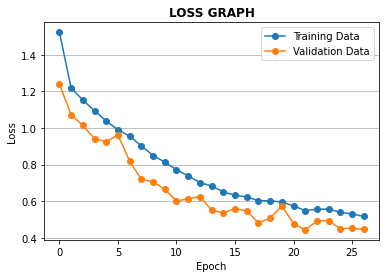

In [7]:
"""Plot training and validation loss during learning process."""

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(fitting.history["loss"], marker = "o", label = "Training Data")  # Plot training loss
plt.plot(fitting.history["val_loss"], marker = "o", label = "Validation Data")  # Plot validation loss

plt.title("LOSS GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(b=1, axis="y")  # Show graph grid
plt.legend()

plt.show()

##ACCURACY VISUALIZATION

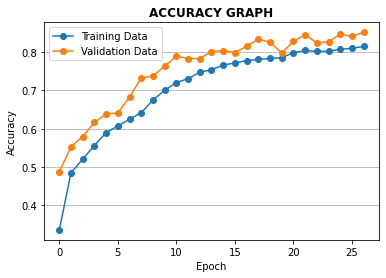

In [8]:
"""Plot training and validation accuracy during learning process."""

import matplotlib.pyplot as plt

plt.plot(fitting.history["accuracy"], marker = "o", label = "Training Data")  # Plot training accuracy
plt.plot(fitting.history["val_accuracy"], marker = "o", label = "Validation Data")  # Plot validation accuracy

plt.title("ACCURACY GRAPH", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(b=1, axis="y")  # Show graph grid
plt.legend()

plt.show()

##TF-Lite Format Model Saving

In [9]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpg7pjdoum/assets


In [10]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

##REFERENCE

###Dataset source: https://www.kaggle.com/puneet6060/intel-image-classification